# Sentiment Classification


Note: I have used following steps in the project
1. Import libs: This is I just imported libruary used in the project
2. Loading the dataset: This step is just data loading IMDB dataset step only with max vocabulary size and splitting it in train and test set which include dependent and independent variable
3. EDA: This step is used for exploring the dataset. Here I have crossed various dateset like vaocab size, unique values of the target variable and also used visualization techniques, seen the average sequence length of the dataset, Standard deviation as well. These step helped me to decide max sequence padding length for padding  
4. word embedding: In this step I have prepared word to index dictionary, index to word dictionary and words list. Also In this I have made a function so to translate the sequence back to words using above dictionary.
5. Model building: Here I have made various model starting with normal neural network model with sequence length of 20 but this model was overfitting, Then I made the same model with sequence length of 300, Then I have done grid search on this model and made final model with improved parameter with sequence length of 300 but here also it was overfitting. Then I have made an LSTM model without pretrained embeddings as this model was underperforming from before models thus I decided to make an LSTM model with pretrained GLOVE embedding, Here I have used GLOVE 100 which encodes each words with 100 embedding dimension.

NOTE I have shown predictions, performance evaluation, performance graph and AUC curve for LSTM with pretrained glove and for normal NN with imporved hyperparameter
6. Output: Here based on above model I have shown the output of each layer and the shape of each layer for 2 different model i.e Final normal model after grid search and LSTM with GLove vector

#  Import libs

In [1]:
#Importing libs
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input, Flatten
from keras.layers import GRU, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import  EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn import metrics
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
import os
from sklearn.metrics import roc_auc_score
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


# Loading the dataset

In [2]:
#Initialize variables
MAX_VOCAB=10000
EMBEDDING_DIM=50
BATCH_SIZE = 100
EPOCHS = 10

In [3]:
#Loading of preprocessed movie review dataset with vocal size 10000 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_VOCAB) # vocab_size is no.of words to consider from the dataset, ordering based on frequency.

In [4]:
#Printing important information about the loaded dataset into train and test
print("Train data length = ",len(x_train))
print("Train label length = ",len(y_train))
print("Test data length = ",len(x_test))
print("Test label length = ",len(y_test))

print("\n")

print("Train data type = ",type(x_train))
print("Train label type = ",type(y_train))
print("Test data type = ",type(x_test))
print("Test label type = ",type(y_test))

print("\n")

print("Train data shape = ",x_train.shape)
print("Train label shape = ",y_train.shape)
print("Test data shape = ",x_test.shape)
print("Test label shape = ",y_test.shape)

Train data length =  25000
Train label length =  25000
Test data length =  25000
Test label length =  25000


Train data type =  <class 'numpy.ndarray'>
Train label type =  <class 'numpy.ndarray'>
Test data type =  <class 'numpy.ndarray'>
Test label type =  <class 'numpy.ndarray'>


Train data shape =  (25000,)
Train label shape =  (25000,)
Test data shape =  (25000,)
Test label shape =  (25000,)


In [5]:
#Cross check step
#Seeing value in train set to see if everything is correct
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [6]:
#Cross check step
#Seeing value in test set to see if everything is correct
print(x_test[4])

[1, 40, 49, 85, 84, 1040, 146, 6, 783, 254, 4386, 337, 5, 13, 447, 14, 500, 10, 10, 14, 500, 517, 1076, 357, 21, 1684, 72, 45, 290, 12, 17, 515, 17, 25, 380, 129, 3305, 4, 2191, 26, 253, 5, 2, 36, 80, 4357, 25, 2, 129, 330, 505, 8, 2, 146, 24, 3988, 14, 500, 9, 82, 2, 5, 9, 1293, 224, 10, 10, 8, 401, 14, 1361, 879, 13, 28, 8, 401, 61, 1642, 2925, 44, 1373, 21, 591, 353, 14, 500, 4092, 30, 290, 12, 10, 10, 65, 790, 790, 206, 158, 300, 45, 15, 52, 2, 158, 692, 2, 158, 856, 158]


# EDA

In [7]:
#print max value( max vocabulary value not vocalbulary size) in train set and printing max seq that any review can have
print("Maximum value of a word index ")
print(max([max(sequence) for sequence in x_train]))
print("Maximum length num words of review in train ")
print(max([len(sequence) for sequence in x_train]))

Maximum value of a word index 
9999
Maximum length num words of review in train 
2494


In [8]:
#print max value( max vocabulary value not vocalbulary size) in test set and printing max seq that any review can have
print("Maximum value of a word index ")
print(max([max(sequence) for sequence in x_test]))
print("Maximum length num words of review in train ")
print(max([len(sequence) for sequence in x_test]))

Maximum value of a word index 
9999
Maximum length num words of review in train 
2315


In [9]:
#Cross check step
#print number of classes in target variable for both train and test set
print("Total classes in test =",np.unique(y_test))
print("Total classes in train = ",np.unique(y_train))

Total classes in test = [0 1]
Total classes in train =  [0 1]


In [10]:
#Cross check step
#To see number of words in both test and train set
print("Total number of words in train = ",len(np.unique(np.hstack(x_train))))
print("Total number of words in test =",len(np.unique(np.hstack(x_test))))

Total number of words in train =  9998
Total number of words in test = 9951


#### Visualize step 

Review length: 
Mean 238.71 words (176.493674)


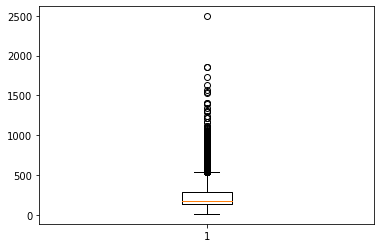

In [11]:
#Visualize step
# Summarize review length for train
#This cell shows how long each review is and based on that it give mean and std of lenght of each sequence
#For train set
print("Review length: ")
result = [len(x) for x in x_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

#Here you can see mean is 238.71 and std 176.49
#This helps us to decide best sequence length

Mean 230.80 words (169.161087)


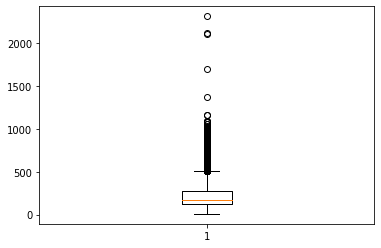

In [12]:
#Visualize step
# Summarize review length for train
#This cell shows how long each review is and based on that it give mean and std of lenght of each sequence
#For train set
result=[len(x) for x in x_test]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
plt.boxplot(result)
plt.show()

#Here you can see mean is 230.80 and std 169.16

# word embedding

In [13]:
#Load original word to index dictionary
voca = imdb.get_word_index()
print(type(voca))

<class 'dict'>


In [14]:
#Getting words into list this gives index to word mapping where each index has a word in that position
#This list has all the words that we want
#This has all the words in the dictionary
#words=['<PAD>','<START>','<UNK>','<UNUSED>']
count=0
words=[]
for w in sorted(voca, key=voca.get):
    if count<=MAX_VOCAB-1:
        words.append(w)
        count+=1

In [15]:
#Cross check steps
#print words in that index
print(words[0])
print(words[1])
print(words[2])
print(words[3])
print(words[4])
print(words[-2])
print(words[-1])
print("\n")
print(len(words))

the
and
a
of
to
beaver
approved


10000


In [16]:
#This steps has all the word to index original mapping but only till vocab size i.e 10000 and they are stored in variable word2idx
#This step also stores index values i.e numbers from 1 to 10000
count=0
word2idx={}
index=[]
for i , j in voca.items():
    if j<=MAX_VOCAB:  #Here it is leass or equal because index starts from 1 as 0 is a special character 
        word2idx[i]=j+3   #Here it is storing dict based on above vocab size condition but with plus 3 as from 0 to 3 are storing special character
        index.append(j+3)

word2idx["<PAD>"] = 0 # This is special character for padding
word2idx["<START>"] = 1 #Start od sequence
word2idx["<UNK>"] = 2  # unknown
word2idx["<UNUSED>"] = 3
    
#Note first 4 are used for special chacter and it starts from 4 

In [17]:
#This is reverse mapping of word to index
#This is dictionary off index to word where key = value and value = word

idx2word={j:i for i,j in word2idx.items()}

In [18]:
#Cross check step where 1st statement i.e word2idx returns value of 2nd dict i.e idx2word and 2nd statement idx2word return 1st dict i.e word2idx value
print(word2idx["approved"])
print(idx2word[10003])

#value of second should match index of 1st

#Note here len is 10003 because first few are speacial character in these dictionay

10003
approved


In [19]:
#Cross check steps which tell if we are doing things right
print(len(word2idx)) #This tells us that our max value is 10004 where first 4 are special words

10004


In [20]:
#Cross check step to see index value of "and" word
word2idx["and"]

5

In [21]:
#Cross check step which compare data from word(list) and word2idx(dict)
#Here I am seeing when i provide i to specific condition word2idx should return some value and on next step if I supply that word it should return the same index
for i , j in voca.items():
    if j==0:
        print("Word corresponds to 0 index = ",i) #This should be 0 as 0 corresponds to special word
        print("We got same word with value = ",word2idx[i])
        print("\n")
    if j==1:
        print("Word corresponds to 3 index = ",i) #Most common word
        print("We got same word with value = ",word2idx[i])
        print("\n")
    if j==2:
        print("Word corresponds to 5 index = ",i) #2nd most common word
        print("We got same word with value = ",word2idx[i])
        print("\n")
    if j==3:
        print("Word corresponds to 6 index = ",i) #3rd most common word
        print("We got same word with value = ",word2idx[i])
        print("\n")
    if j==10000:
        print("Word corresponds to 10003 index = ",i) #Last word
        print("We got same word with value = ",word2idx[i])
        print("\n")
        
#Note first 4 values are special words

Word corresponds to 6 index =  a
We got same word with value =  6


Word corresponds to 10003 index =  approved
We got same word with value =  10003


Word corresponds to 3 index =  the
We got same word with value =  4


Word corresponds to 5 index =  and
We got same word with value =  5




In [22]:
#Cross check step to see word to index mapping
word2idx

{'woods': 1411,
 'hanging': 2348,
 'woody': 2292,
 'arranged': 6749,
 'bringing': 2341,
 'wooden': 1639,
 'errors': 4013,
 'dialogs': 3233,
 'kids': 362,
 'uplifting': 5037,
 'controversy': 7096,
 'projection': 9881,
 'stern': 7183,
 'morally': 5624,
 'wang': 5286,
 'want': 181,
 'travel': 2106,
 'barbra': 6705,
 'dinosaurs': 3933,
 'wrong': 355,
 'subplots': 4763,
 'welcomed': 9095,
 'butcher': 6706,
 'fit': 1183,
 'screaming': 1930,
 'fix': 4290,
 'hurting': 9657,
 'effects': 302,
 'barton': 8778,
 'ingrid': 6195,
 'adapt': 7919,
 'disturbed': 4014,
 'purpose': 1288,
 'olds': 6795,
 'needed': 887,
 'master': 1300,
 'positively': 5402,
 'zatoichi': 9839,
 'feeling': 547,
 'affairs': 5625,
 'wholesome': 7802,
 'cinematic': 1360,
 'tech': 4991,
 'saying': 660,
 'padded': 8425,
 'tempted': 5748,
 'plate': 7479,
 'altogether': 3902,
 'lds': 8779,
 'nicely': 1780,
 'mummy': 4591,
 'lots': 775,
 'lotr': 9262,
 'irs': 9882,
 'ira': 6890,
 'discipline': 7696,
 'nature': 876,
 'superficial': 3

In [23]:
#Cross check step to see index to word mapping
idx2word

{1411: 'woods',
 2348: 'hanging',
 2292: 'woody',
 6749: 'arranged',
 2341: 'bringing',
 1639: 'wooden',
 4013: 'errors',
 3233: 'dialogs',
 362: 'kids',
 5037: 'uplifting',
 7096: 'controversy',
 9881: 'projection',
 7183: 'stern',
 5624: 'morally',
 5286: 'wang',
 181: 'want',
 2106: 'travel',
 6705: 'barbra',
 3933: 'dinosaurs',
 355: 'wrong',
 4763: 'subplots',
 9095: 'welcomed',
 6706: 'butcher',
 1183: 'fit',
 1930: 'screaming',
 4290: 'fix',
 9657: 'hurting',
 302: 'effects',
 8778: 'barton',
 6195: 'ingrid',
 7919: 'adapt',
 4014: 'disturbed',
 1288: 'purpose',
 6795: 'olds',
 887: 'needed',
 1300: 'master',
 5402: 'positively',
 9839: 'zatoichi',
 547: 'feeling',
 5625: 'affairs',
 7802: 'wholesome',
 1360: 'cinematic',
 4991: 'tech',
 660: 'saying',
 8425: 'padded',
 5748: 'tempted',
 7479: 'plate',
 3902: 'altogether',
 8779: 'lds',
 1780: 'nicely',
 4591: 'mummy',
 775: 'lots',
 9262: 'lotr',
 9882: 'irs',
 6890: 'ira',
 7696: 'discipline',
 876: 'nature',
 3903: 'superfici

In [24]:
#This step is visual step where encoding in the dataset is convrted back to readable or alphabetic form 
#Here each integer in the text is matched with the index, and replaced by the corresponding word

def decode(text):
    return ' '.join([idx2word.get(i,"?") for i in text])

In [25]:
#Cross check step
#Provide values and it return decoded output based on decode function
k=decode(x_train[0])
print(k)

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

# MODEL BUILDING:

### NORMAL NN WITH SEQ LEN 20 

In [26]:
#padding train and test set with max sequence length of 20 
SEQ_LEN=20
X_train = pad_sequences(x_train, maxlen=SEQ_LEN, padding='post', truncating="post")
X_test =  pad_sequences(x_test, maxlen=SEQ_LEN, padding='post', truncating="post")

#Note Padding is post padding 

In [27]:
#Cross check step to see shape of both test and train set
#here it should be 20 in shape[1]
print(X_train.shape)
print(X_test.shape)

(25000, 20)
(25000, 20)


In [28]:
#Cross check step
print(type(X_train))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [29]:
#Cross check step to see test values
X_test

array([[   1,  591,  202, ..., 5760,  394,  354],
       [   1,   14,   22, ...,  114,    9,   55],
       [   1,  111,  748, ...,  498, 5076,  748],
       ...,
       [   1,   13, 1408, ...,   45,  184,   78],
       [   1,   11,  119, ...,   86,  107,    8],
       [   1,    6,   52, ...,   47,    6, 3482]])

In [30]:
#Cross check step to see test values
X_train

array([[   1,   14,   22, ...,  256,    5,   25],
       [   1,  194, 1153, ...,  118, 1634,   14],
       [   1,   14,   47, ...,   71,  149,   14],
       ...,
       [   1,   11,    6, ...,    4,  912,   84],
       [   1, 1446, 7079, ...,   54,  349,   11],
       [   1,   17,    6, ...,  270,    2,    5]])

In [31]:
#Cross check step
#Provide values and it return decoded output based on decode function
k=decode(X_train[0])
print(k)

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you


In [32]:
#Cross check step
#Provide values and it return decoded output based on decode function
k=decode(X_train[1])
print(k)

<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this


In [33]:
#Cross check step
#Provide values and it return decoded output based on decode function
k=decode(X_train[2])
print(k)

<START> this has to be one of the worst films of the 1990s when my friends i were watching this


#### MODEL NN 

In [34]:
#Model buliding
model = Sequential()  #Sequential model

model.add(Embedding(MAX_VOCAB, EMBEDDING_DIM, input_length=SEQ_LEN)) #Init embedding layer with no pretrained wts
#embedding layer takes input of vocabulary size i.e 10000, embedding dimension i.e 50 and input sequence i.e number of columns of dataset i.e 20
model.add(Flatten()) #Use flatten layer
model.add(Dropout(0.5))#use dropout for regularization
model.add(Dense(10)) #Hidden layer
model.add(Dropout(0.3))  #use dropout for regularization
model.add(Dense(1, activation='sigmoid')) #Output layer


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [35]:
#To see what our model have, number of layer , output shape ,etc
#model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 50)            500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10010     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 510,021
Trainable params: 510,021
Non-trainable params: 0
________________________________________________

In [36]:
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
#Cross check step to see shape of input to our model
X_train.shape

(25000, 20)

In [38]:
#Fitting model to xtrain and ytrain with defined epochs and batch size
r = model.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_test,y_test)
)



Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 7s 281us/step - loss: 0.6678 - accuracy: 0.5866 - val_loss: 0.6025 - val_accuracy: 0.6713
Epoch 2/10
25000/25000 [==============================] - 7s 280us/step - loss: 0.5222 - accuracy: 0.7432 - val_loss: 0.5621 - val_accuracy: 0.6970
Epoch 3/10
25000/25000 [==============================] - 7s 273us/step - loss: 0.3994 - accuracy: 0.8264 - val_loss: 0.6042 - val_accuracy: 0.6898
Epoch 4/10
25000/25000 [==============================] - 7s 288us/step - loss: 0.2912 - accuracy: 0.8842 - val_loss: 0.6765 - val_accuracy: 0.6783
Epoch 5/10
25000/25000 [==============================] - 7s 262us/step - loss: 0.2089 - accuracy: 0.9213 - val_loss: 0.7787 - val_accuracy: 0.6711
Epoch 6/10
25000/25000 [==============================] - 7s 270us/step - loss: 0.1584 - accuracy: 0.9412 - val_loss: 0.8733 - val_accuracy: 0.6695
Epoch 7/10
25000/25000 [==============================] - 6s 

In [39]:
#Evaluate test set and then print accuracy
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

25000/25000 [==============================] - 1s 45us/step
Test accuracy:  0.6602799892425537


In [40]:
#Evaluate train set and then print accuracy
results = model.evaluate(X_train, y_train)
print('Test accuracy: ', results[1])

25000/25000 [==============================] - 1s 41us/step
Test accuracy:  0.9976400136947632


#### NOTE:
After seeing model performance on dataset with sequence length of 20(which is very less as you cannot get all details in review). The model under performed, the accuarcy is very low and the model was going into overfit zone.
Now lets increase sequence length based on the gaph in visualize steps and some calculation

## NN WITH SEQ LEN 300

In [41]:
#To create list which contain all the sequence length of each review
k=[len(i) for i in x_train]

In [42]:
#Print k
print(k)

[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129, 140, 256, 888, 93, 142, 220, 193, 171, 221, 174, 647, 233, 162, 597, 234, 51, 336, 139, 231, 704, 142, 861, 132, 122, 570, 55, 214, 103, 186, 113, 169, 469, 138, 302, 766, 351, 146, 59, 206, 107, 152, 186, 431, 147, 684, 383, 324, 252, 263, 787, 211, 314, 118, 390, 132, 710, 306, 167, 115, 95, 158, 156, 82, 502, 314, 190, 174, 60, 145, 214, 659, 408, 515, 461, 202, 238, 170, 107, 171, 158, 145, 790, 258, 287, 67, 123, 975, 775, 236, 195, 274, 214, 91, 1038, 815, 183, 206, 50, 118, 147, 141, 60, 56, 439, 439, 213, 144, 533, 303, 203, 563, 129, 153, 55, 92, 174, 187, 183, 165, 78, 198, 156, 223, 127, 61, 362, 84, 57, 176, 159, 57, 159, 165, 213, 194, 149, 130, 203, 19, 98, 466, 525, 130, 322, 153, 408, 215, 472, 143, 136, 354, 260, 319, 125, 209, 282, 810, 142, 240, 148, 198, 193, 123, 128, 103, 479, 345, 263, 165, 205, 333, 184, 92, 177, 335, 120, 121, 259, 180, 160, 114, 59, 343, 513

In [43]:
#To get max value of k
max=0
for i,j in enumerate(k):
    if j>max:
        max=j
print(max)  

2494


In [44]:
#To get max sequence review index
for i,j in enumerate(k):
    if j==max:
        print(i)

17934


In [45]:
#choosing optimul SEQ LEN because previously our model used 20 SEQ LEN where the model performance was not good
#Max sequence length of any sentences is 2494 which is way too much
#Therefore choosing value between 20 and 2494
# this 300 came from the graph above where i plotted avg length and the deviation
SEQ_LEN=300

In [46]:
#padding train and test set
X_train = pad_sequences(x_train, maxlen=SEQ_LEN, padding='post', truncating="post")
X_test =  pad_sequences(x_test, maxlen=SEQ_LEN, padding='post', truncating="post")

In [47]:
#Cross check step to see shape of data if data is padded properly
print(X_train.shape)
print(X_test.shape)

(25000, 300)
(25000, 300)


In [48]:
#Cross check step to see if variable type 
print(type(X_train))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [49]:
#just to see values in test padded set
X_test

array([[   1,  591,  202, ...,    0,    0,    0],
       [   1,   14,   22, ...,    0,    0,    0],
       [   1,  111,  748, ...,   97,   38,  111],
       ...,
       [   1,   13, 1408, ...,    0,    0,    0],
       [   1,   11,  119, ...,    0,    0,    0],
       [   1,    6,   52, ...,    0,    0,    0]])

In [50]:
#just to see values in train padded set
X_train

array([[   1,   14,   22, ...,    0,    0,    0],
       [   1,  194, 1153, ...,    0,    0,    0],
       [   1,   14,   47, ...,    0,    0,    0],
       ...,
       [   1,   11,    6, ...,    0,    0,    0],
       [   1, 1446, 7079, ...,    0,    0,    0],
       [   1,   17,    6, ...,    0,    0,    0]])

In [51]:
#Cross check step
#Provide values and it return decoded output based on decode function
k=decode(X_train[0])
print(k)

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

In [52]:
#Cross check step
#Provide values and it return decoded output based on decode function
k=decode(X_train[1])
print(k)

<START> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal <UNK> the hair is big lots of boobs <UNK> men wear those cut <UNK> shirts that show off their <UNK> sickening that men actually wore them and the music is just <UNK> trash that plays over and over again in almost every scene there is trashy music boobs and <UNK> taking away bodies and the gym still doesn't close for <UNK> all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then <PAD> <PAD> <PAD> <PAD> 

In [53]:
#Cross check step
#Provide values and it return decoded output based on decode function
k=decode(X_train[2])
print(k)

<START> this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had <UNK> working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how <UNK> this is to watch save yourself an hour a bit of your life <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

#### Model building

NOTE: From now on for the rest of the models we will use sequence length of 300

In [54]:
#Model buliding
model = Sequential() #Sequential model

model.add(Embedding(MAX_VOCAB, EMBEDDING_DIM, input_length=SEQ_LEN))  #Init embedding layer with no pretrained wts
#embedding layer takes input of vocabulary size i.e 10000, embedding dimension i.e 50 and input sequence i.e number of columns of dataset i.e 300
model.add(Flatten()) #Use flatten layer
model.add(Dropout(0.5)) #use dropout for regularization
model.add(Dense(10)) #Hidden layer
model.add(Dropout(0.3)) #use dropout for regularization
model.add(Dense(1, activation='sigmoid')) #Output layer


In [55]:
#To see what our model have, number of layer , output shape ,etc
#model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 50)           500000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                150010    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 650,021
Trainable params: 650,021
Non-trainable params: 0
________________________________________________

In [56]:
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [57]:
#Cross check step to see shape of input to our model
X_train.shape

(25000, 300)

In [58]:
#Fitting model to xtrain and ytrain with defined epochs and batch size
r = model.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_test,y_test)
)


Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 18s 701us/step - loss: 0.5398 - accuracy: 0.7072 - val_loss: 0.3430 - val_accuracy: 0.8542
Epoch 2/10
25000/25000 [==============================] - 17s 683us/step - loss: 0.2471 - accuracy: 0.9056 - val_loss: 0.3186 - val_accuracy: 0.8642
Epoch 3/10
25000/25000 [==============================] - 17s 678us/step - loss: 0.1223 - accuracy: 0.9606 - val_loss: 0.3560 - val_accuracy: 0.8599
Epoch 4/10
25000/25000 [==============================] - 18s 702us/step - loss: 0.0606 - accuracy: 0.9822 - val_loss: 0.4003 - val_accuracy: 0.8604
Epoch 5/10
25000/25000 [==============================] - 17s 693us/step - loss: 0.0316 - accuracy: 0.9917 - val_loss: 0.4639 - val_accuracy: 0.8581
Epoch 6/10
25000/25000 [==============================] - 17s 694us/step - loss: 0.0224 - accuracy: 0.9939 - val_loss: 0.5269 - val_accuracy: 0.8537
Epoch 7/10
25000/25000 [==============================] 

In [59]:
#Evaluate test set and then print accuracy
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

25000/25000 [==============================] - 4s 150us/step
Test accuracy:  0.8519600033760071


In [60]:
#Evaluate train set and then print accuracy
results = model.evaluate(X_train, y_train)
print('Test accuracy: ', results[1])

25000/25000 [==============================] - 4s 140us/step
Test accuracy:  0.9999200105667114


#### Note
The accuracy increase when we increased sequence length still model is going toward overfitzone
Lets use grid search to increase accuarcy further

## Grid search 

In [52]:
#Building layes and setting hparams
def build_classifier(optimizer,neurons,EMBEDDING_DIM):
    model = Sequential()
    model.add(Embedding(MAX_VOCAB, EMBEDDING_DIM, input_length=SEQ_LEN))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(neurons))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    
    #adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [53]:
#declaring hyper parameter such as neurons, batch_size, optimizers and embedding dimension to get their best values
#Then fitting it to data set
model = KerasClassifier(build_fn = build_classifier,epochs=8, verbose=1)
parameters = {'batch_size': [75,125],
              'neurons': [5,10,15,20],
              'optimizer': ['adam', 'rmsprop'],
              'EMBEDDING_DIM':[30,50,70]
             }
grid_search = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3)

In [54]:
#Fitting to dataset
grid_search = grid_search.fit(X_train, y_train)

Epoch 1/8
16666/16666 [==============================] - 3s 158us/step - loss: 0.6201 - accuracy: 0.6474
Epoch 2/8
16666/16666 [==============================] - 3s 156us/step - loss: 0.3198 - accuracy: 0.8822
Epoch 3/8
16666/16666 [==============================] - 3s 150us/step - loss: 0.1916 - accuracy: 0.9368
Epoch 4/8
16666/16666 [==============================] - 3s 153us/step - loss: 0.1119 - accuracy: 0.9696
Epoch 5/8
16666/16666 [==============================] - 2s 150us/step - loss: 0.0707 - accuracy: 0.9815
Epoch 6/8
16666/16666 [==============================] - 3s 159us/step - loss: 0.0436 - accuracy: 0.9899
Epoch 7/8
16666/16666 [==============================] - 3s 151us/step - loss: 0.0309 - accuracy: 0.9929
Epoch 8/8
8334/8334 [==============================] - 0s 23us/step
Epoch 1/8
16667/16667 [==============================] - 3s 154us/step - loss: 0.6382 - accuracy: 0.6201
Epoch 2/8
16667/16667 [==============================] - 3s 151us/step - loss: 0.3238 - accu

16666/16666 [==============================] - 3s 186us/step - loss: 0.5908 - accuracy: 0.6612
Epoch 2/8
16666/16666 [==============================] - 3s 172us/step - loss: 0.2684 - accuracy: 0.8945
Epoch 3/8
16666/16666 [==============================] - 3s 179us/step - loss: 0.1283 - accuracy: 0.9549
Epoch 4/8
16666/16666 [==============================] - 3s 175us/step - loss: 0.0643 - accuracy: 0.9800
Epoch 5/8
16666/16666 [==============================] - 3s 183us/step - loss: 0.0401 - accuracy: 0.9875
Epoch 6/8
16666/16666 [==============================] - 3s 176us/step - loss: 0.0274 - accuracy: 0.9920
Epoch 7/8
16666/16666 [==============================] - 3s 175us/step - loss: 0.0200 - accuracy: 0.9938
Epoch 8/8
8334/8334 [==============================] - 1s 71us/step
Epoch 1/8
16667/16667 [==============================] - 3s 187us/step - loss: 0.5991 - accuracy: 0.6591
Epoch 2/8
16667/16667 [==============================] - 3s 177us/step - loss: 0.2740 - accuracy: 0.89

16666/16666 [==============================] - 2s 142us/step - loss: 0.4184 - accuracy: 0.8376
Epoch 3/8
16666/16666 [==============================] - 2s 138us/step - loss: 0.2765 - accuracy: 0.8990
Epoch 4/8
16666/16666 [==============================] - 2s 139us/step - loss: 0.2032 - accuracy: 0.9304
Epoch 5/8
16666/16666 [==============================] - 2s 141us/step - loss: 0.1519 - accuracy: 0.9509
Epoch 6/8
16666/16666 [==============================] - 2s 141us/step - loss: 0.1147 - accuracy: 0.9639
Epoch 7/8
16666/16666 [==============================] - 2s 141us/step - loss: 0.0848 - accuracy: 0.9738
Epoch 8/8
8334/8334 [==============================] - 1s 84us/step
Epoch 1/8
16667/16667 [==============================] - 3s 158us/step - loss: 0.6633 - accuracy: 0.5987
Epoch 2/8
16667/16667 [==============================] - 2s 138us/step - loss: 0.4335 - accuracy: 0.8313
Epoch 3/8
16667/16667 [==============================] - 2s 138us/step - loss: 0.2927 - accuracy: 0.88

16666/16666 [==============================] - 3s 181us/step - loss: 0.6223 - accuracy: 0.6426
Epoch 2/8
16666/16666 [==============================] - 3s 156us/step - loss: 0.3433 - accuracy: 0.8594
Epoch 3/8
16666/16666 [==============================] - 3s 152us/step - loss: 0.2193 - accuracy: 0.9176
Epoch 4/8
16666/16666 [==============================] - 3s 153us/step - loss: 0.1496 - accuracy: 0.9456
Epoch 5/8
16666/16666 [==============================] - 3s 152us/step - loss: 0.1032 - accuracy: 0.9632
Epoch 6/8
16666/16666 [==============================] - 3s 153us/step - loss: 0.0697 - accuracy: 0.9771
Epoch 7/8
16666/16666 [==============================] - 3s 152us/step - loss: 0.0449 - accuracy: 0.9857
Epoch 8/8
8334/8334 [==============================] - 1s 131us/step
Epoch 1/8
16667/16667 [==============================] - 3s 179us/step - loss: 0.6382 - accuracy: 0.6279
Epoch 2/8
16667/16667 [==============================] - 3s 152us/step - loss: 0.3563 - accuracy: 0.8

16666/16666 [==============================] - 5s 329us/step - loss: 0.5699 - accuracy: 0.6910
Epoch 2/8
16666/16666 [==============================] - 5s 293us/step - loss: 0.2773 - accuracy: 0.8917
Epoch 3/8
16666/16666 [==============================] - 5s 292us/step - loss: 0.1560 - accuracy: 0.9416
Epoch 4/8
16666/16666 [==============================] - 5s 296us/step - loss: 0.0848 - accuracy: 0.9711
Epoch 5/8
16666/16666 [==============================] - 5s 294us/step - loss: 0.0448 - accuracy: 0.9852
Epoch 6/8
16666/16666 [==============================] - 5s 292us/step - loss: 0.0285 - accuracy: 0.9899
Epoch 7/8
16666/16666 [==============================] - 5s 295us/step - loss: 0.0172 - accuracy: 0.9945
Epoch 8/8
8334/8334 [==============================] - 2s 202us/step
Epoch 1/8
16667/16667 [==============================] - 6s 337us/step - loss: 0.5725 - accuracy: 0.6821
Epoch 2/8
16667/16667 [==============================] - 5s 297us/step - loss: 0.2773 - accuracy: 0.8

16666/16666 [==============================] - 5s 271us/step - loss: 0.3452 - accuracy: 0.8647
Epoch 3/8
16666/16666 [==============================] - 5s 274us/step - loss: 0.2102 - accuracy: 0.9262
Epoch 4/8
16666/16666 [==============================] - 5s 271us/step - loss: 0.1305 - accuracy: 0.9564
Epoch 5/8
16666/16666 [==============================] - 5s 272us/step - loss: 0.0749 - accuracy: 0.9782
Epoch 6/8
16666/16666 [==============================] - 5s 273us/step - loss: 0.0446 - accuracy: 0.9882
Epoch 7/8
16666/16666 [==============================] - 5s 273us/step - loss: 0.0265 - accuracy: 0.9931
Epoch 8/8
8334/8334 [==============================] - 2s 242us/step
Epoch 1/8
16667/16667 [==============================] - 5s 316us/step - loss: 0.6268 - accuracy: 0.6420
Epoch 2/8
16667/16667 [==============================] - 5s 270us/step - loss: 0.3433 - accuracy: 0.8673
Epoch 3/8
16667/16667 [==============================] - 5s 272us/step - loss: 0.2172 - accuracy: 0.9

16666/16666 [==============================] - 5s 286us/step - loss: 0.1214 - accuracy: 0.9629
Epoch 4/8
16666/16666 [==============================] - 5s 287us/step - loss: 0.0542 - accuracy: 0.9877
Epoch 5/8
16666/16666 [==============================] - 5s 290us/step - loss: 0.0281 - accuracy: 0.9942
Epoch 6/8
16666/16666 [==============================] - 5s 287us/step - loss: 0.0168 - accuracy: 0.9966
Epoch 7/8
16666/16666 [==============================] - 5s 288us/step - loss: 0.0117 - accuracy: 0.9981
Epoch 8/8
8334/8334 [==============================] - 2s 280us/step
Epoch 1/8
16667/16667 [==============================] - 6s 339us/step - loss: 0.6235 - accuracy: 0.6404
Epoch 2/8
16667/16667 [==============================] - 5s 288us/step - loss: 0.2847 - accuracy: 0.8918
Epoch 3/8
16667/16667 [==============================] - 5s 286us/step - loss: 0.1276 - accuracy: 0.9582
Epoch 4/8
16667/16667 [==============================] - 5s 290us/step - loss: 0.0564 - accuracy: 0.9

Epoch 4/8
16666/16666 [==============================] - 8s 478us/step - loss: 0.0281 - accuracy: 0.9942
Epoch 5/8
16666/16666 [==============================] - 8s 475us/step - loss: 0.0142 - accuracy: 0.9980
Epoch 6/8
16666/16666 [==============================] - 8s 479us/step - loss: 0.0092 - accuracy: 0.9986
Epoch 7/8
16666/16666 [==============================] - 8s 476us/step - loss: 0.0074 - accuracy: 0.9986
Epoch 8/8
8334/8334 [==============================] - 3s 372us/step
Epoch 1/8
16667/16667 [==============================] - 9s 548us/step - loss: 0.5691 - accuracy: 0.6809
Epoch 2/8
16667/16667 [==============================] - 8s 478us/step - loss: 0.2240 - accuracy: 0.9158
Epoch 3/8
16667/16667 [==============================] - 8s 478us/step - loss: 0.0719 - accuracy: 0.9828
Epoch 4/8
16667/16667 [==============================] - 8s 478us/step - loss: 0.0289 - accuracy: 0.9945
Epoch 5/8
16667/16667 [==============================] - 8s 479us/step - loss: 0.0140 - acc

Epoch 5/8
16666/16666 [==============================] - 8s 476us/step - loss: 0.0285 - accuracy: 0.9906
Epoch 6/8
16666/16666 [==============================] - 8s 474us/step - loss: 0.0160 - accuracy: 0.9949
Epoch 7/8
16666/16666 [==============================] - 8s 477us/step - loss: 0.0107 - accuracy: 0.9965
Epoch 8/8
8334/8334 [==============================] - 3s 419us/step
Epoch 1/8
16667/16667 [==============================] - 9s 551us/step - loss: 0.5684 - accuracy: 0.6906
Epoch 2/8
16667/16667 [==============================] - 8s 481us/step - loss: 0.2547 - accuracy: 0.8991
Epoch 3/8
16667/16667 [==============================] - 8s 476us/step - loss: 0.1245 - accuracy: 0.9570
Epoch 4/8
16667/16667 [==============================] - 9s 546us/step - loss: 0.0598 - accuracy: 0.9800
Epoch 5/8
16667/16667 [==============================] - 8s 478us/step - loss: 0.0278 - accuracy: 0.9909
Epoch 6/8
16667/16667 [==============================] - 8s 481us/step - loss: 0.0168 - acc

16666/16666 [==============================] - 7s 420us/step - loss: 0.0133 - accuracy: 0.9962
Epoch 8/8
8334/8334 [==============================] - 4s 455us/step
Epoch 1/8
16667/16667 [==============================] - 9s 518us/step - loss: 0.5977 - accuracy: 0.6677
Epoch 2/8
16667/16667 [==============================] - 7s 418us/step - loss: 0.2992 - accuracy: 0.8827
Epoch 3/8
16667/16667 [==============================] - 7s 420us/step - loss: 0.1670 - accuracy: 0.9409
Epoch 4/8
16667/16667 [==============================] - 7s 420us/step - loss: 0.0891 - accuracy: 0.9742
Epoch 5/8
16667/16667 [==============================] - 7s 420us/step - loss: 0.0423 - accuracy: 0.9890
Epoch 6/8
16667/16667 [==============================] - 7s 417us/step - loss: 0.0228 - accuracy: 0.9935
Epoch 7/8
16667/16667 [==============================] - 7s 417us/step - loss: 0.0125 - accuracy: 0.9963
Epoch 8/8
8333/8333 [==============================] - 4s 453us/step
Epoch 1/8
16667/16667 [=========

In [55]:
#print best hyperparameter based on above run
best_parameters = grid_search.best_params_
print(best_parameters)

{'EMBEDDING_DIM': 30, 'batch_size': 125, 'neurons': 5, 'optimizer': 'adam'}


In [56]:
#print best accuracy
best_accuracy = grid_search.best_score_
print(best_accuracy)

0.87368


## Final model 
This model is bulit after getting optimal hparameter from grid search

In [63]:
#Model buliding
model = Sequential() #Sequential model

model.add(Embedding(MAX_VOCAB, 30, input_length=SEQ_LEN))  #Init embedding layer with no pretrained wts
#embedding layer takes input of vocabulary size i.e 10000, embedding dimension i.e 50 and input sequence i.e number of columns of dataset i.e 300
model.add(Flatten()) #Use flatten layer
model.add(Dropout(0.5)) #use dropout for regularization
model.add(Dense(5)) #Hidden layer
model.add(Dropout(0.3)) #use dropout for regularization
model.add(Dense(1, activation='sigmoid')) #Output layer

In [64]:
#To see what our model have, number of layer , output shape ,etc
#model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 30)           300000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 9000)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 9000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 45005     
_________________________________________________________________
dropout_6 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 345,011
Trainable params: 345,011
Non-trainable params: 0
________________________________________________

In [65]:
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [66]:
#Cross check step to see shape of input to our model
X_train.shape

(25000, 300)

In [67]:
#Define early stop and reduced lr
stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1, mode="min") 

In [68]:
#Fitting model to xtrain and ytrain with defined epochs and batch size
#Here I have used requlaization and model performance tech such as reduced lr and early stop
r = model.fit(
  X_train,
  y_train,
  batch_size=125,
  epochs=EPOCHS,
 # callbacks=[reduce_lr, stop],
  validation_data=(X_test,y_test)
)


Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 4s 160us/step - loss: 0.6175 - accuracy: 0.6468 - val_loss: 0.4197 - val_accuracy: 0.8282
Epoch 2/10
25000/25000 [==============================] - 4s 153us/step - loss: 0.3155 - accuracy: 0.8812 - val_loss: 0.3153 - val_accuracy: 0.8675
Epoch 3/10
25000/25000 [==============================] - 4s 161us/step - loss: 0.2062 - accuracy: 0.9272 - val_loss: 0.3119 - val_accuracy: 0.8716
Epoch 4/10
25000/25000 [==============================] - 4s 155us/step - loss: 0.1387 - accuracy: 0.9565 - val_loss: 0.3361 - val_accuracy: 0.8670
Epoch 5/10
25000/25000 [==============================] - 4s 156us/step - loss: 0.0941 - accuracy: 0.9727 - val_loss: 0.3674 - val_accuracy: 0.8657
Epoch 6/10
25000/25000 [==============================] - 4s 158us/step - loss: 0.0629 - accuracy: 0.9826 - val_loss: 0.4043 - val_accuracy: 0.8644
Epoch 7/10
25000/25000 [==============================] - 4s 1

In [69]:
#Evaluate test set and then print accuracy
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

25000/25000 [==============================] - 1s 30us/step
Test accuracy:  0.8585600256919861


In [70]:
#Evaluate train set and then print accuracy
results = model.evaluate(X_train, y_train)
print('Test accuracy: ', results[1])

25000/25000 [==============================] - 1s 30us/step
Test accuracy:  0.9999200105667114


In [71]:
#Getting prediction of test set and train set
prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

In [72]:
#print prediction
print(prediction_test)

[[0.00270584]
 [1.        ]
 [0.9998786 ]
 ...
 [0.00501606]
 [0.41706505]
 [0.5904646 ]]


In [73]:
#Set threshold
#we want the value to be either 0 or 1
pred=np.zeros((25000,))
count=0
for i in prediction_test:
    if i>0.5:  #Got .5 after many hit and try
        pred[count]=1
    
    else:
        pred[count]=0
    
    count+=1

#Threshold is 0.5

In [74]:
#print value after threshold
pred

array([0., 1., 1., ..., 0., 0., 1.])

In [75]:
#print accuracy score, f1 score, precision, recall and classification report
print("accuracy : {0:.4f}".format(accuracy_score(y_test,pred)))
print("F1 score : {0:.4f}".format(f1_score(y_test,pred)))
print("precision score : {0:.4f}".format(precision_score(y_test,pred)))
print("recall score : {0:.4f}".format(recall_score(y_test,pred)))
print(metrics.classification_report(y_test,pred))

accuracy : 0.8586
F1 score : 0.8548
precision score : 0.8784
recall score : 0.8324
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     12500
           1       0.88      0.83      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



#### Plotting model performance

In [76]:
#To see what out model stores info so that these can be plotted
print(r.history)

{'val_loss': [0.41967814072966575, 0.31534422516822813, 0.31188236258924007, 0.3360690650343895, 0.3673982647806406, 0.40433042369782923, 0.44931577399373057, 0.4807850980758667, 0.5205187710374594, 0.5577785823494196], 'val_accuracy': [0.8281999826431274, 0.8674799799919128, 0.8715599775314331, 0.8670399785041809, 0.8656799793243408, 0.8644400238990784, 0.8596799969673157, 0.8620399832725525, 0.8589199781417847, 0.8585600256919861], 'loss': [0.6174829252064228, 0.3154584526270628, 0.20619698014110327, 0.1386769899353385, 0.09410732259973884, 0.0628730616811663, 0.04597682327032089, 0.03829919936135411, 0.027760785922873767, 0.022568860789760947], 'accuracy': [0.6468, 0.88124, 0.9272, 0.95652, 0.97268, 0.98264, 0.988, 0.98936, 0.99252, 0.99392]}


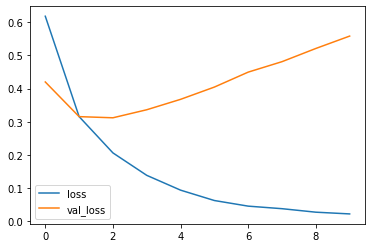

In [77]:
# plot model loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

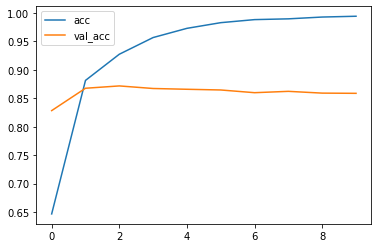

In [78]:
#plot model accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

#### AUC 

In [79]:
#print AUC for train set
aucs = []
for j in range(6):
    auc = roc_auc_score(y_train, prediction_train)
    aucs.append(auc)
print(np.mean(aucs))


0.9999995520000001


In [80]:
#print AUC for test set
aucs = []
for j in range(6):
    auc = roc_auc_score(y_test, prediction_test)
    aucs.append(auc)
print(np.mean(aucs))

0.9339280992


#### Some predictions 

In [81]:
#Init value for that prediction
n=4

In [82]:
print("X_test shape = ",X_test.shape) #To see shape of X_test

x=X_test[n]  #Put test value in x
print("Shape of x = ",x.shape)
#AS you can see it is out of shape when comared to x_test because it is a single value therefore we need to reshape it

x2=x.reshape(1,SEQ_LEN) #Reshape to (1,300) so to put in our model if not done this step it will throw error as our model accept this shape only

print("New Shape of x = ",x2.shape) #Cross check step to see our new shape

P=model.predict(x2) #predict x based on our model

P2 = 1 if P>0.5 else 0  #Setting threshold if value less than 0.5 it is -ve review otherwise poistive

print("\n")
print("Predicted review = ",P2) #predicted review
print("Actual value = ",y_test[n])

X_test shape =  (25000, 300)
Shape of x =  (300,)
New Shape of x =  (1, 300)


Predicted review =  1
Actual value =  1


In [83]:
#This returns the decoded value by using above decoded function
k=decode(X_test[n])
print(k)

<START> like some other people wrote i'm a die hard mario fan and i loved this game br br this game starts slightly boring but trust me it's worth it as soon as you start your hooked the levels are fun and <UNK> they will hook you <UNK> your mind turns to <UNK> i'm not kidding this game is also <UNK> and is beautifully done br br to keep this spoiler free i have to keep my mouth shut about details but please try this game it'll be worth it br br story 9 9 action 10 1 it's that good <UNK> 10 attention <UNK> 10 average 10 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

## LSTM WOTHOUT PRE-TRAINED WTS

In [84]:
#Model buliding
model2 = Sequential()  #Sequential model
model2.add(Embedding(MAX_VOCAB, EMBEDDING_DIM, input_length=SEQ_LEN)) #Init embedding layer with no pretrained wts
#embedding layer takes input of vocabulary size i.e 10000, embedding dimension i.e 50 and input sequence i.e number of columns of dataset i.e 300
#Here I am not using pretrained glove vector
model2.add(Dropout(0.3)) #use dropout for regularization
model2.add(LSTM(100,return_sequences=True, dropout=0.3))  #Hidden layer with dropout Here return_sequences=true as I want to get output from all layer than apply global max pool over all the output so that I dont miss out important info
model2.add(GlobalMaxPool1D()) #This is to get values from all states and not missing important info
model2.add(Dense(1, activation="sigmoid")) #Final dense layer 

#Note:GlobalMaxPool1D requires output from all lSTMs therfore reurn_sequences = True, this returns output from all LSTM not just final LSTM 
#ALso GlobalMaxPool1D takes max of all output in very special way this step is done so that every words wether at start or at he end is given importance. 

In [85]:
#To see what our model have, number of layer , output shape ,etc
#model summary
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 50)           500000    
_________________________________________________________________
dropout_7 (Dropout)          (None, 300, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 100)          60400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 560,501
Trainable params: 560,501
Non-trainable params: 0
_________________________________________________________________


In [86]:
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy
model2.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [87]:
#Fitting model to xtrain and ytrain with defined epochs and batch size
r = model2.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_test,y_test),
  verbose=1
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 102s 4ms/step - loss: 0.6099 - accuracy: 0.6868 - val_loss: 0.3755 - val_accuracy: 0.8482
Epoch 2/10
25000/25000 [==============================] - 101s 4ms/step - loss: 0.3049 - accuracy: 0.8752 - val_loss: 0.3984 - val_accuracy: 0.8370
Epoch 3/10
25000/25000 [==============================] - 103s 4ms/step - loss: 0.2254 - accuracy: 0.9136 - val_loss: 0.3031 - val_accuracy: 0.8720
Epoch 4/10
25000/25000 [==============================] - 102s 4ms/step - loss: 0.1829 - accuracy: 0.9315 - val_loss: 0.3496 - val_accuracy: 0.8636
Epoch 5/10
25000/25000 [==============================] - 102s 4ms/step - loss: 0.1544 - accuracy: 0.9450 - val_loss: 0.3445 - val_accuracy: 0.8596
Epoch 6/10
25000/25000 [==============================] - 103s 4ms/step - loss: 0.1336 - accuracy: 0.9532 - val_loss: 0.3732 - val_accuracy: 0.8585
Epoch 7/10
25000/25000 [==============================] - 103s

In [88]:
#Evaluate test set and then print accuracy
results = model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

25000/25000 [==============================] - 31s 1ms/step
Test accuracy:  0.8523200154304504


In [89]:
#Evaluate train set and then print accuracy
results = model2.evaluate(X_train, y_train)
print('Test accuracy: ', results[1])

25000/25000 [==============================] - 35s 1ms/step
Test accuracy:  0.9905200004577637


#### NOTE:
This LSTM without pretrained wts is also overfitting and results are also not that good lets use LSTM with glove vector. 

## LSTM WITH PRE-TRAINED GLOVE VECTOR

#### Load glove vector 

In [61]:
#load Pretrained glove vector from file
#Note the pretrained are of 100 dim long as I am using it from 'glove.6B.100d. This embed each word with 100 dimensions

print('Loading word vectors...')
word2vec = {} #This dict contain all wrod to vec of golve model
with open(os.path.join(os.getcwd()+'\\glove.6B.100d.txt'),encoding="utf8") as f: #import data from file
    for line in f:
        values = line.split() 
        word2 = values[0]  #Store value in the variable
        vec = np.asarray(values[1:], dtype='float32') #store vector of that word to different variable
        word2vec[word2] = vec
        #print(values)
        
print('Found %s word vectors.' % len(word2vec)) #print lenth of the dict that stored value

Loading word vectors...
Found 400000 word vectors.


In [62]:
#this is that embedding from word2vec that are in word2idx in our dataset
#This steps store only those vectors that are there in our dictionary word2idx
#Only those word's vectors that are there in our vocabulary
EMBEDDING_DIM=100 #As we are using GLOVE 100
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB, len(word2idx) + 1) #Set threshold
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM)) #init array to store embedding
for word, i in word2idx.items():
    if i < MAX_VOCAB:
        embedding_vector = word2vec.get(word) #Get pretrained glove vector from word2vec that are there in our vocalbulary and stroe in some other variable one by one
        #print(embedding_vector)
        if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector
        
#Note the embedding_matrix is nothing but the pretrained glove vector from file 'glove.6B.100d.txt' but has only those words that are there in our dictionary

Filling pre-trained embeddings...


In [63]:
#cross check step
#To see if everthing is done properly

print(num_words) #To see threshold 

print(embedding_matrix.shape)

#AS you can see the output of embedding_matrix which is 10000 in length and 50 in dim

10000
(10000, 100)


In [64]:
#Cross check to see a dummy value
embedding_matrix[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Model Building LSTM


In [75]:
#Model buliding
model2 = Sequential()  #Sequential model
model2.add(Embedding(MAX_VOCAB, EMBEDDING_DIM, input_length=SEQ_LEN, weights=[embedding_matrix], trainable=True)) #Init embedding layer with no pretrained wts
#embedding layer takes input of vocabulary size i.e 10000, embedding dimension i.e 50 and input sequence i.e number of columns of dataset i.e 300
#Here I am using pretrained glove vector stored in variable 
model2.add(Dropout(0.5)) #use dropout for regularization embedding_matrix
model2.add(LSTM(100,return_sequences=True, dropout=0.4))  #Hidden layer with dropout Here return_sequences=true as I want to get output from all layer than apply global max pool over all the output so that I dont miss out important info
model2.add(GlobalMaxPool1D()) #This is to get values from all states and not missing important info
model2.add(Dense(1, activation="sigmoid")) #Final dense layer 
#Note:GlobalMaxPool1D requires output from all lSTMs therfore reurn_sequences = True, this returns output from all LSTM not just final LSTM 
#ALso GlobalMaxPool1D takes max of all output in very special way this step is done so that every words wether at start or at he end is given importance. 

In [76]:
#To see what our model have, number of layer , output shape ,etc
#model summary
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 300, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 100)          80400     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


In [77]:
#Compile model with optimizer adam, loss as binary cross entropy and metric is accuracy
model2.compile(
  loss='binary_crossentropy',
  #optimizer=Adam(lr=0.01),  #best
  optimizer='adam',
  metrics=['acc']
)

In [78]:
#Define checkpoint, early stop and reduced lr
stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1, mode="min") 

In [79]:
#Fitting model to xtrain and ytrain with defined epochs and batch size
#Here I have used requlaization and model performance tech such as reduced lr, check point and early stop
EPOCHS=10
r = model2.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=(X_test,y_test),
  callbacks=[reduce_lr, stop],
  verbose=1
)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 173s 7ms/step - loss: 0.6027 - acc: 0.6603 - val_loss: 0.4449 - val_acc: 0.7908
Epoch 2/10
25000/25000 [==============================] - 175s 7ms/step - loss: 0.4264 - acc: 0.8055 - val_loss: 0.3397 - val_acc: 0.8537
Epoch 3/10
25000/25000 [==============================] - 174s 7ms/step - loss: 0.3593 - acc: 0.8464 - val_loss: 0.3648 - val_acc: 0.8523
Epoch 4/10
25000/25000 [==============================] - 174s 7ms/step - loss: 0.3220 - acc: 0.8634 - val_loss: 0.3266 - val_acc: 0.8714
Epoch 5/10
25000/25000 [==============================] - 175s 7ms/step - loss: 0.2985 - acc: 0.8749 - val_loss: 0.2887 - val_acc: 0.8834
Epoch 6/10
25000/25000 [==============================] - 175s 7ms/step - loss: 0.2777 - acc: 0.8850 - val_loss: 0.2818 - val_acc: 0.8842
Epoch 7/10
25000/25000 [==============================] - 176s 7ms/step - loss: 0.2590 - acc: 0.8927 - val_loss: 0.2766 - 

In [81]:
#Evaluate test set and then print accuracy
results = model2.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])

25000/25000 [==============================] - 36s 1ms/step
Test accuracy:  0.8956400156021118


In [82]:
#Evaluate train set and then print accuracy
results = model2.evaluate(X_train, y_train)
print('Test accuracy: ', results[1])

25000/25000 [==============================] - 36s 1ms/step
Test accuracy:  0.9401999711990356


In [83]:
#Getting prediction of test set and train set
prediction_train2 = model2.predict(X_train)
prediction_test2 = model2.predict(X_test)

In [84]:
#print prediction
print(prediction_test2)

[[0.01150385]
 [0.9953797 ]
 [0.9725683 ]
 ...
 [0.0026525 ]
 [0.03272676]
 [0.15806133]]


In [85]:
#Set threshold
#we want the value to be either 0 or 1
pred2=np.zeros((25000,))
count=0
for i in prediction_test2:
    if i>0.5:  #Got .5 after many hit and try
        pred2[count]=1
    
    else:
        pred2[count]=0
    
    count+=1
        
#threshold is 0.5

In [86]:
#print value after threshold
pred2

array([0., 1., 1., ..., 0., 0., 0.])

In [87]:
#print accuracy score, f1 score, precision, recall and classification report
print("accuracy : {0:.4f}".format(accuracy_score(y_test,pred2)))
print("F1 score : {0:.4f}".format(f1_score(y_test,pred2)))
print("precision score : {0:.4f}".format(precision_score(y_test,pred2)))
print("recall score : {0:.4f}".format(recall_score(y_test,pred2)))
print(metrics.classification_report(y_test,pred2))

accuracy : 0.8956
F1 score : 0.8966
precision score : 0.8888
recall score : 0.9045
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     12500
           1       0.89      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



#### Plotting model performance

In [88]:
#To see what out model stores info so that these can be plotted
print(r.history)

{'val_loss': [0.4449035955667496, 0.3396933563947678, 0.3648205891251564, 0.326638181656599, 0.2887175160348415, 0.28176495325565337, 0.2765772679448128, 0.26885333260893823, 0.2709451336562633, 0.26571866223216056], 'val_acc': [0.7908400297164917, 0.8537200093269348, 0.8523200154304504, 0.8713600039482117, 0.8833600282669067, 0.8842399716377258, 0.8893600106239319, 0.8927199840545654, 0.894599974155426, 0.8956400156021118], 'loss': [0.602748440861702, 0.4264164352416992, 0.35930150574445724, 0.322038579583168, 0.29847083616256714, 0.27765644431114195, 0.25904917052388193, 0.24345125898718833, 0.23433869951963424, 0.22287024840712547], 'acc': [0.66032, 0.80552, 0.84636, 0.86336, 0.87488, 0.885, 0.89272, 0.90192, 0.903, 0.9114], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


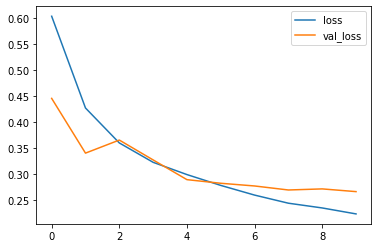

In [89]:
# plot model loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

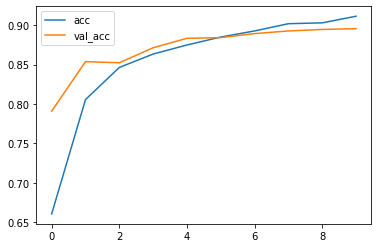

In [90]:
#plot model accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

#### AUC 

In [91]:
#print AUC for train set
aucs2 = []
for j in range(6):
    auc2 = roc_auc_score(y_train, prediction_train2)
    aucs2.append(auc2)
print(np.mean(aucs2))


0.984149616


In [92]:
#print AUC for test set
aucs2 = []
for j in range(6):
    auc2 = roc_auc_score(y_test, prediction_test2)
    aucs2.append(auc2)
print(np.mean(aucs2))

0.9623555615999999


#### Some predictions

In [93]:
#Init value for that prediction
n=4

In [94]:
print("X_test shape = ",X_test.shape) #To see shape of X_test

x=X_test[n]  #Put test value in x
print("Shape of x = ",x.shape)
#AS you can see it is out of shape when comared to x_test because it is a single value therefore we need to reshape it

x2=x.reshape(1,SEQ_LEN) #Reshape to (1,300) so to put in our model if not done this step it will throw error as our model accept this shape only

print("New Shape of x = ",x2.shape) #Cross check step to see our new shape

P=model2.predict(x2) #predict x based on our model

P2 = 1 if P>0.5 else 0  #Setting threshold if value less than 0.5 it is -ve review otherwise poistive

print("\n")
print("Predicted review = ",P2) #predicted review
print("Actual value = ",y_test[n])

X_test shape =  (25000, 300)
Shape of x =  (300,)
New Shape of x =  (1, 300)


Predicted review =  1
Actual value =  1


In [95]:
#This returns the decoded value by using above decoded function
k=decode(X_test[n])
print(k)

<START> like some other people wrote i'm a die hard mario fan and i loved this game br br this game starts slightly boring but trust me it's worth it as soon as you start your hooked the levels are fun and <UNK> they will hook you <UNK> your mind turns to <UNK> i'm not kidding this game is also <UNK> and is beautifully done br br to keep this spoiler free i have to keep my mouth shut about details but please try this game it'll be worth it br br story 9 9 action 10 1 it's that good <UNK> 10 attention <UNK> 10 average 10 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

#### Note:
This model of LSTM with wts is best till now it has best performance without overfitting 

# Retrive the output of each layer in keras for a given single test sample from the trained model you built

## OUTPUT FOR NORMAL SEQUENTIAL MODEL 

In [96]:
#Here you can see what all layers are used, shape of each layer an dtype
print(model.layers[0].output)
print(model.layers[1].output)
print(model.layers[2].output)
print(model.layers[3].output)
print(model.layers[4].output)
print(model.layers[5].output)

Tensor("embedding_2/embedding_lookup/Identity_1:0", shape=(?, 300, 50), dtype=float32)
Tensor("flatten_2/Reshape:0", shape=(?, ?), dtype=float32)
Tensor("dropout_3/cond/Merge:0", shape=(?, ?), dtype=float32)
Tensor("dense_3/BiasAdd:0", shape=(?, 10), dtype=float32)
Tensor("dropout_4/cond/Merge:0", shape=(?, 10), dtype=float32)
Tensor("dense_4/Sigmoid:0", shape=(?, 1), dtype=float32)


In [97]:
n=2

In [98]:
print("X_test shape = ",X_test.shape) #To see shape of X_test

x=X_test[n]  #Put test value in x
print("Shape of x = ",x.shape)
#AS you can see it is out of shape when comared to x_test because it is a single value therefore we need to reshape it

x2=x.reshape(1,SEQ_LEN) #Reshape to (1,300) so to put in our model if not done this step it will throw error as our model accept this shape only

print("New Shape of x = ",x2.shape) #Cross check step to see our new shape

P=model.predict(x2) #predict x based on our model

P2 = 1 if P>0.5 else 0  #Setting threshold if value less than 0.5 it is -ve review otherwise poistive
print("Predicted review",P2) #predicted review
print("Actual review",y_test[n]) #To compare pridicted result with actual result

X_test shape =  (25000, 300)
Shape of x =  (300,)
New Shape of x =  (1, 300)
Predicted review 1
Actual review 1


In [99]:
#use this step to cross check output shape
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 50)           500000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                150010    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 650,021
Trainable params: 650,021
Non-trainable params: 0
________________________________________________

In [100]:
#Here you can see I made use of keras backend to initliaze, It returns the output of each layer when invoked 
#As the model is sequential I have to provide value to first layer and it will give output till final layer 
#Here inside function you can see model.layer which are model layer followed by index which mean that particular layer, followed by the input which is the input to that layer or out is we will get output from that layer
#This is done for all layers that are in my model
get_embed_out0 = keras.backend.function(
    [model.layers[0].input],
    [model.layers[0].output])

get_embed_out1 = keras.backend.function(
    [model.layers[0].input],
    [model.layers[1].output])

get_embed_out2 = keras.backend.function(
    [model.layers[0].input],
    [model.layers[2].output])

get_embed_out3 = keras.backend.function(
    [model.layers[0].input],
    [model.layers[3].output])

get_embed_out4 = keras.backend.function(
    [model.layers[0].input],
    [model.layers[4].output])

get_embed_out5 = keras.backend.function(
    [model.layers[0].input],
    [model.layers[5].output])

In [101]:
#Shape, type and length of each layer from embedding till dense final layer
#Here input is the x2(reshaped of x)
#This step gives us important details about the what shape each layers gives out
layer_output0 = get_embed_out0([x2]) #Init our input to above function and creating object of it similarly for rest
layer_output1 = get_embed_out1([x2])
layer_output2 = get_embed_out2([x2])
layer_output3 = get_embed_out3([x2])
layer_output4 = get_embed_out4([x2])
layer_output5 = get_embed_out5([x2])

print("for layer 1st i.e Flatten layer =   ", type(layer_output0), len(layer_output0), layer_output0[0].shape)
print("for layer 2nd i.e Flatten layer =   ", type(layer_output1), len(layer_output1), layer_output1[0].shape)
print("for layer 3rd i.e 1st Dropout layer =   ",type(layer_output2), len(layer_output2), layer_output2[0].shape)
print("for layer 4th i.e Dense layer =   ",type(layer_output3), len(layer_output3), layer_output3[0].shape)
print("for layer 5th i.e 2nd Dropout layer =   ",type(layer_output4), len(layer_output4), layer_output4[0].shape)
print("for layer 6th i.e dense layer =   ",type(layer_output5), len(layer_output5), layer_output5[0].shape)

for layer 1st i.e Flatten layer =    <class 'list'> 1 (1, 300, 50)
for layer 2nd i.e Flatten layer =    <class 'list'> 1 (1, 15000)
for layer 3rd i.e 1st Dropout layer =    <class 'list'> 1 (1, 15000)
for layer 4th i.e Dense layer =    <class 'list'> 1 (1, 10)
for layer 5th i.e 2nd Dropout layer =    <class 'list'> 1 (1, 10)
for layer 6th i.e dense layer =    <class 'list'> 1 (1, 1)


In [102]:
#Output for all layers from embedding till dense final layer
#Here I have show each layer output based on our input value x2(reshaped of x)
print("For layer 1 i.e Embedding layer")
print(layer_output0)

print("\n\n For layer 2 i.e Flatten layer")
print(layer_output1)

print("\n\n For layer 3 i.e 1st Dropout layer")
print(layer_output2)

print("\n\n For layer 4 i.e Dense layer")
print(layer_output3)

print("\n\n For layer 5 i.e 2nd Dropout layer")
print(layer_output4)

print("\n\n For layer 6 i.e dense layer")
print(layer_output5)

For layer 1 i.e Embedding layer
[array([[[ 5.66664312e-05, -1.79680102e-02,  8.28240719e-03, ...,
          3.40049528e-03, -2.71884049e-03,  4.18313732e-03],
        [-7.95939714e-02,  1.58535223e-02, -1.65786128e-02, ...,
          7.43049458e-02, -2.50634663e-02,  4.92246076e-02],
        [-1.31525407e-02, -1.58749130e-02,  4.36166413e-02, ...,
          1.32223743e-03, -1.60870922e-03, -2.37565897e-02],
        ...,
        [ 6.48019984e-02,  6.91158175e-02, -4.78430912e-02, ...,
          6.13603331e-02,  3.37494463e-02,  1.21757602e-02],
        [-2.71052518e-03,  2.82813944e-02, -4.88941781e-02, ...,
         -1.83668882e-02,  1.02251165e-01, -3.11347526e-02],
        [-7.95939714e-02,  1.58535223e-02, -1.65786128e-02, ...,
          7.43049458e-02, -2.50634663e-02,  4.92246076e-02]]],
      dtype=float32)]


 For layer 2 i.e Flatten layer
[array([[ 5.6666431e-05, -1.7968010e-02,  8.2824072e-03, ...,
         7.4304946e-02, -2.5063466e-02,  4.9224608e-02]], dtype=float32)]


 Fo

## OUTPUT FOR LSTM MODEL (with pretrained weights)

In [103]:
#Here you can see what all layers are used, shape of each layer an dtype
print(model2.layers[0].output)
print(model2.layers[1].output)
print(model2.layers[2].output)
print(model2.layers[3].output)
print(model2.layers[4].output)

Tensor("embedding_5/embedding_lookup/Identity_1:0", shape=(?, 300, 100), dtype=float32)
Tensor("dropout_7/cond/Merge:0", shape=(?, 300, 100), dtype=float32)
Tensor("lstm_3/transpose_1:0", shape=(?, 300, 100), dtype=float32)
Tensor("global_max_pooling1d_3/Max:0", shape=(?, 100), dtype=float32)
Tensor("dense_7/Sigmoid:0", shape=(?, 1), dtype=float32)


In [104]:

print("X_test shape = ",X_test.shape) #To see shape of X_test

x=X_test[n]  #Put test value in x
print("Shape of x = ",x.shape)
#AS you can see it is out of shape when comared to x_test because it is a single value therefore we need to reshape it

x2=x.reshape(1,SEQ_LEN) #Reshape to (1,300) so to put in our model if not done this step it will throw error as our model accept this shape only

print("New Shape of x = ",x2.shape) #Cross check step to see our new shape

P=model2.predict(x2) #predict x based on our model

P2 = 1 if P>0.5 else 0  #Setting threshold if value less than 0.5 it is -ve review otherwise poistive
print("Predicted review",P2) #predicted review
print("Actual review",y_test[n]) #To compare pridicted result with actual result

X_test shape =  (25000, 300)
Shape of x =  (300,)
New Shape of x =  (1, 300)
Predicted review 1
Actual review 1


In [105]:
#use this step to cross check output shape 
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 300, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 300, 100)          80400     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


In [106]:
#Here you can see I made use of keras backend to initliaze, It returns the output of each layer when invoked 
#As the model is sequential I have to provide value to first layer and it will give output till final layer 
#Here inside function you can see model.layer which are model layer followed by index which mean that particular layer, followed by the input which is the input to that layer or out is we will get output from that layer
#This is done for all layers that are in my model
get_embed_out0 = keras.backend.function(
    [model2.layers[0].input],
    [model2.layers[0].output])

get_embed_out1 = keras.backend.function(
    [model2.layers[0].input],
    [model2.layers[1].output])

get_embed_out2 = keras.backend.function(
    [model2.layers[0].input],
    [model2.layers[2].output])

get_embed_out3 = keras.backend.function(
    [model2.layers[0].input],
    [model2.layers[3].output])

get_embed_out4 = keras.backend.function(
    [model2.layers[0].input],
    [model2.layers[4].output])


In [109]:
#Shape, type and length of each layer from embedding till dense final layer
#Here input is the x2(reshaped of x)
#This step gives us important details about the what shape each layers gives out
layer_output0 = get_embed_out0([x2]) #Init our input to above function and creating object of it similarly for rest 
layer_output1 = get_embed_out1([x2])
layer_output2 = get_embed_out2([x2])
layer_output3 = get_embed_out3([x2])
layer_output4 = get_embed_out4([x2])


print("for layer 1st i.e Embedding layer =   ", type(layer_output0), len(layer_output0), layer_output0[0].shape)
print("for layer 2nd i.e Dropout layer =   ", type(layer_output1), len(layer_output1), layer_output1[0].shape)
print("for layer 3rd i.e LSTM layer =   ",type(layer_output2), len(layer_output2), layer_output2[0].shape)
print("for layer 4th i.e global_max_pooling1d =   ",type(layer_output3), len(layer_output3), layer_output3[0].shape)
print("for layer 5th i.e Dense layer =   ",type(layer_output4), len(layer_output4), layer_output4[0].shape)

for layer 1st i.e Embedding layer =    <class 'list'> 1 (1, 300, 100)
for layer 2nd i.e Dropout layer =    <class 'list'> 1 (1, 300, 100)
for layer 3rd i.e LSTM layer =    <class 'list'> 1 (1, 300, 100)
for layer 4th i.e global_max_pooling1d =    <class 'list'> 1 (1, 100)
for layer 5th i.e Dense layer =    <class 'list'> 1 (1, 1)


In [110]:
#Output for all layers from embedding till dense final layer
#Here I have show each layer output based on our input value x2(reshaped of x)
print("For layer 1 i.e Embedding layer")
print(layer_output0)

print("\n\n For layer 2 i.e Dropout layer")
print(layer_output1)

print("\n\n For layer 3 i.e LSTM layer")
print(layer_output2)

print("\n\n For layer 4 i.e global_max_pooling1d")
print(layer_output3)

print("\n\n For layer 5 i.e Dense layer")
print(layer_output4)


For layer 1 i.e Embedding layer
[array([[[ 0.04729347,  0.04208159,  0.04265385, ...,  0.06871387,
          0.05492609, -0.00377948],
        [-0.30647343,  0.78726465, -0.20184797, ..., -0.06453719,
          0.58388066,  0.5944857 ],
        [ 0.4920982 ,  0.21363993, -0.03415488, ..., -0.521059  ,
          0.84319484,  0.11655941],
        ...,
        [-0.18036468,  0.071647  ,  0.197794  , ..., -0.5258234 ,
          0.648752  ,  0.05700096],
        [-0.42847362,  0.41960958,  0.5360627 , ..., -0.20482133,
         -0.10294092,  0.2667207 ],
        [-0.30647343,  0.78726465, -0.20184797, ..., -0.06453719,
          0.58388066,  0.5944857 ]]], dtype=float32)]


 For layer 2 i.e Dropout layer
[array([[[ 0.04729347,  0.04208159,  0.04265385, ...,  0.06871387,
          0.05492609, -0.00377948],
        [-0.30647343,  0.78726465, -0.20184797, ..., -0.06453719,
          0.58388066,  0.5944857 ],
        [ 0.4920982 ,  0.21363993, -0.03415488, ..., -0.521059  ,
          0.84319484

# Conclusion:

I have performed various important steps in this project starting from EDA which helped me to know my dataset proper than I Done embedding step which include various sub step like creating different dictionary eg word2idx and idx2word also in in this I have created a function which maps the sequences back to word. Then next step comes is Model biluding step here I have created various model strating from normal Neural network dense model with sequence length of 20 then cearted sam emodel with 300 sequence length then performed grid search on that and prepared final model with improved hyperparameter with 300 sequence length but again the model was overfitting, Then I decided to make LSTM model with and withour pretrained word embeddings, the one with pretrained wts performed very well and I have also printed its results and predictions alsong with performance graph. At the end I have shown each layers output and output shape for lstm with pretrained wts and normal dense neural network with improved hyyperparameter. Also now I would finally conclude in production I would use LSTM with pretrained wts because it was giving great results without overfitting   